Loading Data from Kaggle Datasets


In [0]:
from google.colab import files

#!pip install -q kaggle

In [0]:
ls

In [28]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [37]:
cd /content

/content


In [38]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:07<00:00, 148MB/s]



In [0]:
!chmod 600 /root/.kaggle/kaggle.json

test/  train/  val/


Extracting the images from the zip file


In [0]:
import zipfile
with zipfile.ZipFile("chest-xray-pneumonia.zip") as zip_ref:
  zip_ref.extractall()

In [0]:
with zipfile.ZipFile("chest_xray.zip") as zip_ref:
  zip_ref.extractall()

Importing the required libraries

In [0]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
import os
from keras.applications.inception_v3 import InceptionV3
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from random import shuffle
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Dropout, Activation, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [44]:
print(os.listdir('../content/chest_xray/'))
TRAIN_NORMAL_DIR = '../content/chest_xray/train/NORMAL'
TRAIN_PNEUM_DIR = '../content/chest_xray/train/PNEUMONIA'
TEST_NORMAL_DIR = '../content/chest_xray/test/NORMAL'
TEST_PNEUM_DIR = '../content/chest_xray/test/PNEUMONIA'
VAL_NORMAL_DIR = '../content/chest_xray/val/NORMAL'
VAL_PNEUM_DIR = '../content/chest_xray/val/PNEUMONIA'

['train', 'test', 'val', '.DS_Store']


Loading the images and converting them into numpy arrays

In [46]:
X_train = []
X_test = []
X_val = []
y_train = []
y_test = []
y_val = []

def convert_images(dir, categ):
  for img in tqdm(os.listdir(dir)):
    if (img == '.DS_Store'):
      continue;
    path = os.path.join(dir, img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150, 150))
    if (dir.find('train') >= 0 or dir.find('val') >= 0):
      X_train.append(np.array(img))
      y_train.append(categ)
    elif (dir.find('test') >= 0):
      X_test.append(np.array(img))
      y_test.append(categ)
    #else:
    #  X_val.append(np.array(img))
    #  y_val.append(categ)

convert_images(TRAIN_NORMAL_DIR, "normal");
convert_images(TRAIN_PNEUM_DIR, "pneumonia");
convert_images(TEST_NORMAL_DIR, "normal");
convert_images(TEST_PNEUM_DIR, "pneumonia");
convert_images(VAL_NORMAL_DIR, "normal");
convert_images(VAL_PNEUM_DIR, "pneumonia");


100%|██████████| 9/9 [00:00<00:00, 134.40it/s]


In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)
#X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
#y_val = np.array(y_val)

In [48]:
print(X_train.shape)
print(X_test.shape)
#print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
#print(y_val.shape)

(5232, 150, 150, 3)
(624, 150, 150, 3)
(5232,)
(624,)


Rescaling X data and performing one-hot encoding on y data 


In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

#y_val = le.fit_transform(y_val)

In [0]:
X_train = X_train/255
X_test = X_test/255
#X_val = X_val/255

Visualizing some of the x-rays

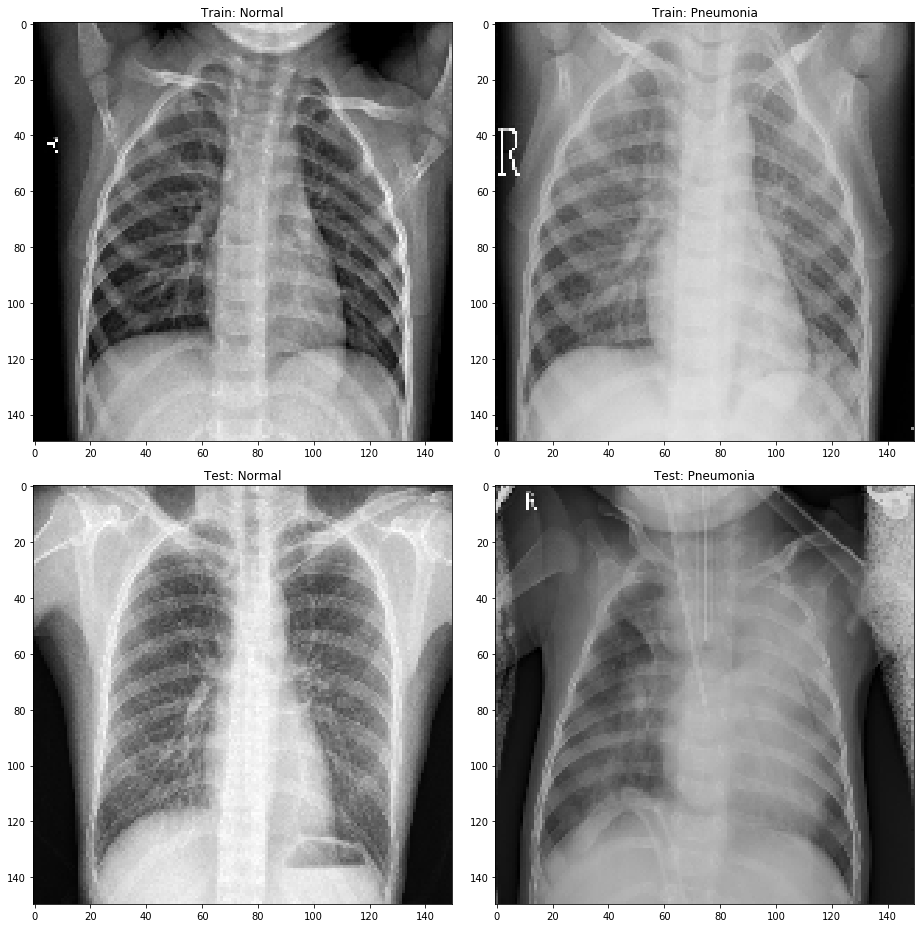

In [51]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(13, 13)

ax[0, 0].imshow(X_train[0])
ax[0, 0].set_title("Train: "+("Pneumonia" if y_train[0] else "Normal"))
ax[1, 0].imshow(X_test[0])
ax[1, 0].set_title("Test: "+("Pneumonia" if y_test[0] else "Normal"))
#ax[2, 0].imshow(X_val[0])
#ax[2, 0].set_title("Val: "+("Pneumonia" if y_val[0] else "Normal"))

ax[0, 1].imshow(X_train[-1])
ax[0, 1].set_title("Train: "+("Pneumonia" if y_train[-1] else "Normal"))
ax[1, 1].imshow(X_test[-1])
ax[1, 1].set_title("Test: "+("Pneumonia" if y_test[-1] else "Normal"))
#ax[2, 1].imshow(X_val[-1])
#ax[2, 1].set_title("Val: "+("Pneumonia" if y_val[-1] else "Normal"))

plt.tight_layout()

Splitting training data into training and validation

In [0]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [0]:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.25,
                                                  random_state = 42)

In [61]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(3924, 150, 150, 3)
(1308, 150, 150, 3)
(3924,)
(1308,)


Performing transfer learning using Inception V3

In [62]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (150, 150, 3), pooling = 'avg')

87916544/87910968 [==============================] - 2s 0us/step


In [63]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [0]:
model = Sequential()
model.add(base_model)
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

In [76]:
epochs = 50
batch_size = 64
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 22,360,482
Trainable params: 22,326,050
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
base_model.trainable = False

model.compile(optimizer = Adam(lr = 0.001), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          epochs = epochs, batch_size = batch_size, 
          callbacks=[checkpointer], verbose=1)